In [23]:
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt

from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float64

r = 90
dt = 0.01
T = 126.48

upperx = 1*2
lowerx = -0.5*2

uppery = 0.3*2
lowery = -0.1*2

#デバイス関数を定義しておく
@cuda.jit('f8(f8, f8)', device=True)
def fhn_xdot(x, y):
    return x*(x+0.1)*(1-x)-y
@cuda.jit('f8(f8, f8)', device=True)
def fhn_ydot(x, y):
    return (x-0.5*y)/100

@cuda.jit
def rk4_gpu_fhn(pf, rng_states, upperx, lowerx, uppery, lowery, t, itter, dt):
    k, j = cuda.grid(2)

    x = xoroshiro128p_uniform_float64(rng_states, k*r+j)*(upperx-lowerx)+lowerx
    y = xoroshiro128p_uniform_float64(rng_states, k*r+j)*(uppery-lowery)+lowery
    for i in range(itter):
        pf[k, j, i] = x, y
        for _ in range(t):
            k_1x = fhn_xdot(x,y)
            k_1y = fhn_ydot(x,y)
            k_2x = fhn_xdot(x+k_1x/2*dt,y+k_1y/2*dt)
            k_2y = fhn_ydot(x+k_1x/2*dt,y+k_1y/2*dt)
            k_3x = fhn_xdot(x+k_2x/2*dt,y+k_2y/2*dt)
            k_3y = fhn_ydot(x+k_2x/2*dt,y+k_2y/2*dt)
            k_4x = fhn_xdot(x+k_3x*dt,y+k_3y*dt)
            k_4y = fhn_ydot(x+k_3x*dt,y+k_3y*dt)

            x+=((k_1x+2*k_2x+2*k_3x+k_4x)/6*dt)
            y+=((k_1y+2*k_2y+2*k_3y+k_4y)/6*dt)

rng_states = create_xoroshiro128p_states(r*r, seed=1)

griddim=r
blockdim=1, r

itter = 1000
log_interval = int(T/(100*dt)) # 周期の100分の1ごとに記録

pf_1T = np.empty((r, r, itter, 2))

rk4_gpu_fhn[griddim, blockdim](pf_1T, rng_states, upperx*10, lowerx*10, uppery*10, lowery*10, log_interval, itter, dt)


c:\Users\Sota\anaconda3\envs\numba\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 90 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\Sota\anaconda3\envs\numba\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


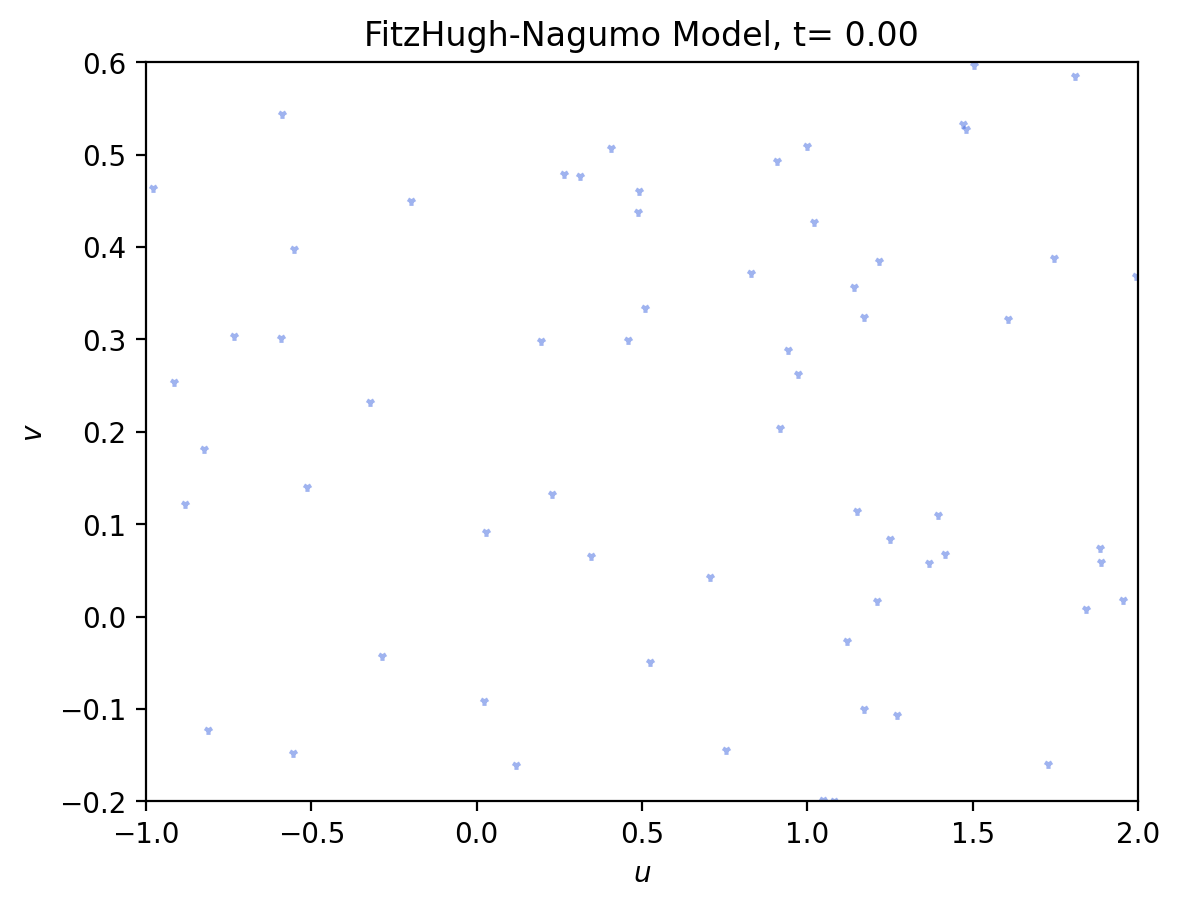

In [25]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(dpi=200)

def update(i):
    ax.cla()
    ax.set_xlim(lowerx, upperx)
    ax.set_ylim(lowery, uppery)
    ax.scatter(pf_1T[:, :, i, :].T[0], pf_1T[:, :, i, :].T[1], c="royalblue", s=10, alpha=0.5, marker="1")
    ax.set_title(f"FitzHugh-Nagumo Model, t={(i*(log_interval*dt)): .2f}")
    ax.set_xlabel(r"$u$")
    ax.set_ylabel(r"$v$")

ani = FuncAnimation(fig, update, frames=range(itter), interval=100)
ani.save('fhn.mp4', writer="ffmpeg")

In [26]:
# 周期ごとに記録
itter = 100
log_interval = int(T/dt)
pf_1T = np.empty((r, r, itter, 2))

rk4_gpu_fhn[griddim, blockdim](pf_1T, rng_states, upperx*10, lowerx*10, uppery*10, lowery*10, log_interval, itter, dt)

c:\Users\Sota\anaconda3\envs\numba\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


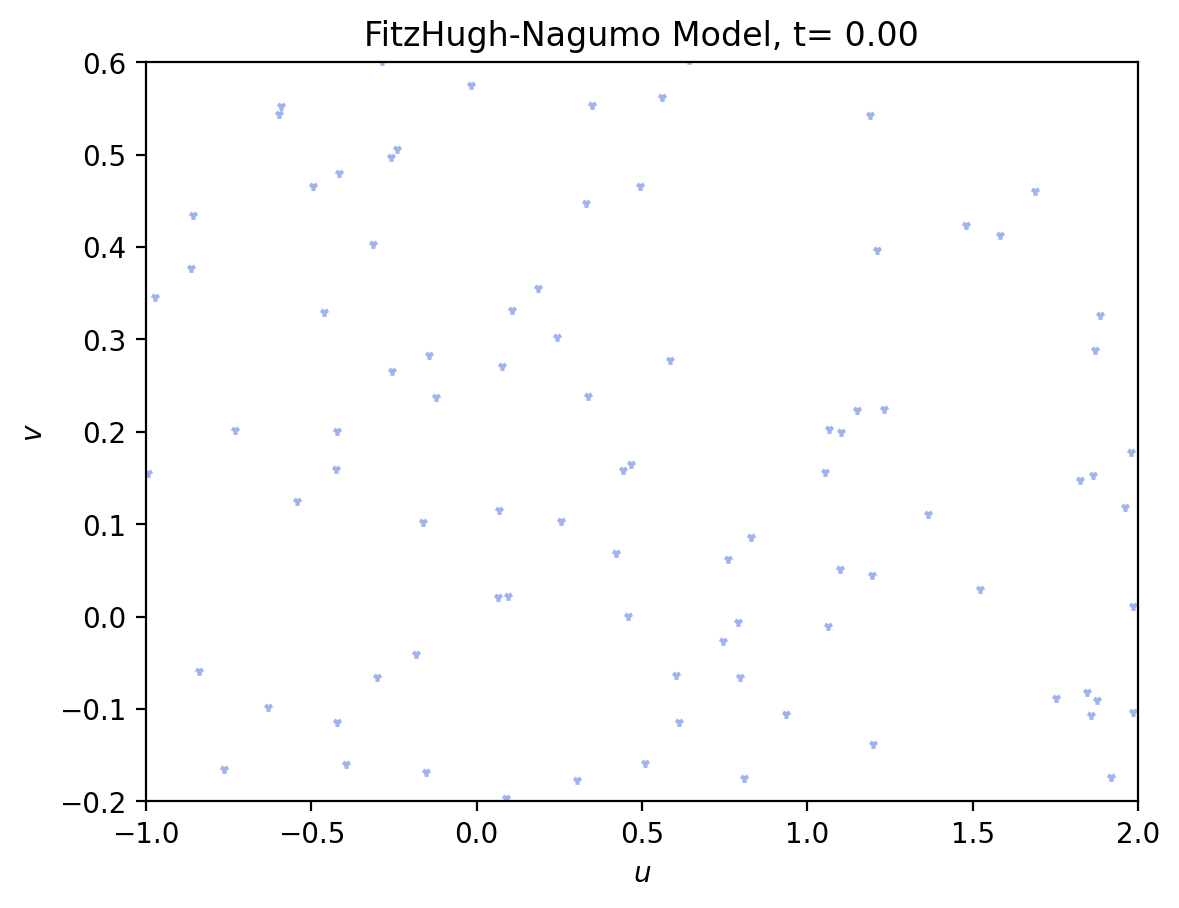

In [27]:
fig, ax = plt.subplots(dpi=200)

# Initial scatter plot

def update(i):
    ax.cla()
    ax.set_xlim(lowerx, upperx)
    ax.set_ylim(lowery, uppery)
    ax.scatter(pf_1T[:, :, i, :].T[0], pf_1T[:, :, i, :].T[1], c="royalblue", s=10, alpha=0.5, marker="1")
    ax.set_title(f"FitzHugh-Nagumo Model, t={(i*(log_interval*dt)): .2f}")
    ax.set_xlabel(r"$u$")
    ax.set_ylabel(r"$v$")

ani = FuncAnimation(fig, update, frames=range(int(itter)), interval=1000)

ani.save('fhn_strobo.mp4', writer="ffmpeg")